# Brain-Inspired Dynamic Attention for NLP
## Complete Implementation: Preprocessing → Training → Evaluation

This notebook implements a brain-inspired attention mechanism that:
1. Learns to identify important words (Importance Scorer)
2. Selectively allocates attention based on importance (Dynamic Attention)
3. Compares efficiency vs. standard full attention

## Part 1: Setup and Data Loading
Load the preprocessed data from your data preparation notebook

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

✓ Libraries imported
✓ Using device: cpu


In [2]:
# Load preprocessed data
train_df = pd.read_csv('data_train.csv')
val_df = pd.read_csv('data_val.csv')
test_df = pd.read_csv('data_test.csv')

# Load word importance dictionary
with open('word_importance_dict.pkl', 'rb') as f:
    word_importance = pickle.load(f)

print(f"✓ Loaded data:")
print(f"  Training: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")
print(f"  Vocabulary: {len(word_importance)} words")

✓ Loaded data:
  Training: 6 samples
  Validation: 1 samples
  Test: 2 samples
  Vocabulary: 325 words


## Part 2: Build Vocabulary and Word Embeddings
Create simple word embeddings for our model

In [3]:
# Build vocabulary from all words
vocab = {'<PAD>': 0, '<UNK>': 1}  # Special tokens
for word in word_importance.keys():
    if word not in vocab:
        vocab[word] = len(vocab)

vocab_size = len(vocab)
print(f"✓ Vocabulary built: {vocab_size} tokens")

# Helper function to convert tokens to indices
def tokens_to_indices(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

# Helper function to parse stored arrays (they're saved as strings in CSV)
def parse_array_string(s):
    if isinstance(s, str):
        # Remove brackets and split
        s = s.strip('[]')
        if not s:
            return np.array([])
        return np.array([float(x.strip()) for x in s.split()])
    return np.array(s)

def parse_token_string(s):
    if isinstance(s, str):
        # Remove quotes and brackets, split by comma or space
        s = s.strip("[]'\"")
        tokens = [t.strip("' \"") for t in s.split() if t.strip("' \"")]
        return tokens
    return s

✓ Vocabulary built: 327 tokens


## Part 3: Create PyTorch Dataset
Prepare data for training

In [4]:
class ImportanceDataset(Dataset):
    """Dataset for training importance scorer"""
    
    def __init__(self, df, vocab, max_length=100):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Parse tokens and labels
        tokens = parse_token_string(row['tokens'])
        importance_scores = parse_array_string(row['importance_scores'])
        key_word_labels = parse_array_string(row['key_word_labels'])
        
        # Convert tokens to indices
        token_ids = tokens_to_indices(tokens, self.vocab)
        
        # Truncate or pad
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]
            importance_scores = importance_scores[:self.max_length]
            key_word_labels = key_word_labels[:self.max_length]
        else:
            pad_length = self.max_length - len(token_ids)
            token_ids = token_ids + [self.vocab['<PAD>']] * pad_length
            importance_scores = np.concatenate([importance_scores, np.zeros(pad_length)])
            key_word_labels = np.concatenate([key_word_labels, np.zeros(pad_length)])
        
        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1 if tid != self.vocab['<PAD>'] else 0 for tid in token_ids]
        
        return {
            'token_ids': torch.LongTensor(token_ids),
            'attention_mask': torch.FloatTensor(attention_mask),
            'importance_scores': torch.FloatTensor(importance_scores),
            'labels': torch.LongTensor(key_word_labels.astype(int))
        }

# Create datasets
train_dataset = ImportanceDataset(train_df, vocab)
val_dataset = ImportanceDataset(val_df, vocab)
test_dataset = ImportanceDataset(test_df, vocab)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"✓ Datasets created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ Datasets created
  Train batches: 3
  Val batches: 1
  Test batches: 1


## Part 4: Build the Importance Scorer Model
This neural network learns to predict which words are important

In [5]:
class ImportanceScorer(nn.Module):
    """Neural network that learns to predict word importance"""
    
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32):
        super(ImportanceScorer, self).__init__()
        
        # Word embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Bidirectional LSTM to capture context
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # Classification head: predict if word is important
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 2)  # Binary: important or not
        )
        
    def forward(self, token_ids, attention_mask=None):
        # Embed tokens
        embeddings = self.embedding(token_ids)  # [batch, seq_len, embedding_dim]
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(embeddings)  # [batch, seq_len, hidden_dim*2]
        
        # Classify each word
        logits = self.classifier(lstm_out)  # [batch, seq_len, 2]
        
        return logits
    
    def predict_importance(self, token_ids, attention_mask=None):
        """Get importance predictions (0 or 1) for each word"""
        with torch.no_grad():
            logits = self.forward(token_ids, attention_mask)
            predictions = torch.argmax(logits, dim=-1)
            return predictions

# Initialize model
importance_model = ImportanceScorer(vocab_size, embedding_dim=64, hidden_dim=32).to(device)
print(f"✓ Importance Scorer model created")
print(f"  Parameters: {sum(p.numel() for p in importance_model.parameters()):,}")

✓ Importance Scorer model created
  Parameters: 48,162


## Part 5: Train the Importance Scorer
Train the model to identify important words

In [6]:
def train_importance_scorer(model, train_loader, val_loader, epochs=20, lr=0.001):
    """Train the importance scorer model"""
    
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore padding
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print("\nTraining Importance Scorer...\n")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in train_loader:
            token_ids = batch['token_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            logits = model(token_ids, attention_mask)
            
            # Reshape for loss calculation
            logits_flat = logits.view(-1, 2)
            labels_flat = labels.view(-1)
            
            # Only compute loss on non-padded tokens
            mask_flat = attention_mask.view(-1).bool()
            loss = criterion(logits_flat[mask_flat], labels_flat[mask_flat])
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            predictions = torch.argmax(logits_flat, dim=-1)
            train_correct += (predictions[mask_flat] == labels_flat[mask_flat]).sum().item()
            train_total += mask_flat.sum().item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                token_ids = batch['token_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                logits = model(token_ids, attention_mask)
                
                logits_flat = logits.view(-1, 2)
                labels_flat = labels.view(-1)
                mask_flat = attention_mask.view(-1).bool()
                
                loss = criterion(logits_flat[mask_flat], labels_flat[mask_flat])
                val_loss += loss.item()
                
                predictions = torch.argmax(logits_flat, dim=-1)
                val_correct += (predictions[mask_flat] == labels_flat[mask_flat]).sum().item()
                val_total += mask_flat.sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    print("\n✓ Training complete!")
    return history

# Train the model
history = train_importance_scorer(importance_model, train_loader, val_loader, epochs=20)


Training Importance Scorer...

Epoch 5/20
  Train Loss: 0.6353 | Train Acc: 0.6947
  Val Loss:   0.6170 | Val Acc:   0.7033
Epoch 10/20
  Train Loss: 0.6176 | Train Acc: 0.6947
  Val Loss:   0.6102 | Val Acc:   0.7033
Epoch 15/20
  Train Loss: 0.6152 | Train Acc: 0.6947
  Val Loss:   0.6118 | Val Acc:   0.7033
Epoch 20/20
  Train Loss: 0.6255 | Train Acc: 0.6947
  Val Loss:   0.6103 | Val Acc:   0.7033

✓ Training complete!


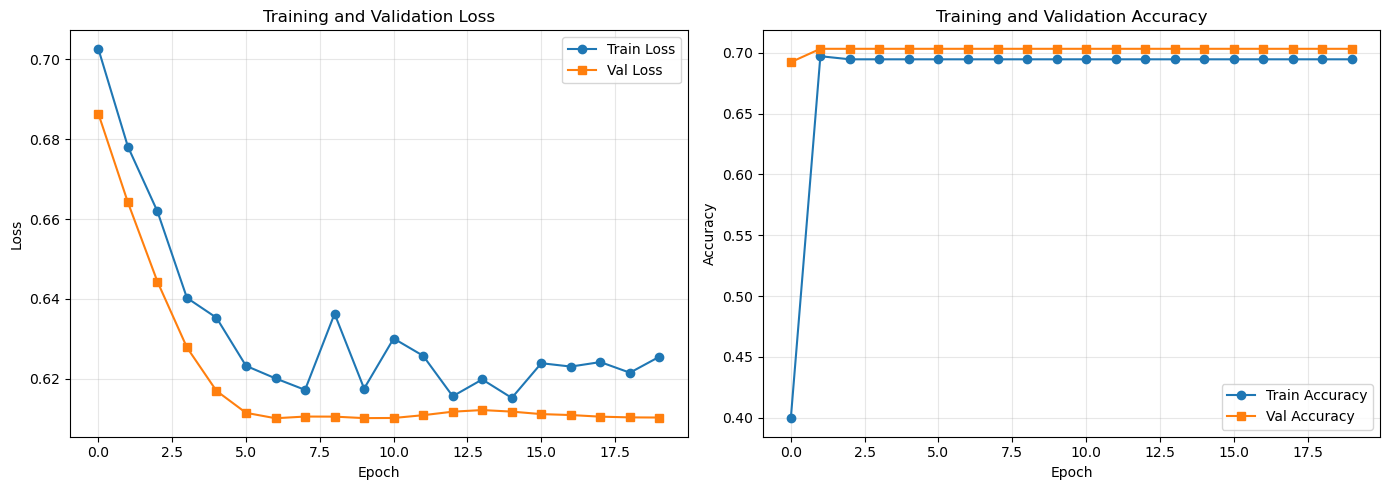


Final Results:
  Train Accuracy: 0.6947
  Val Accuracy: 0.7033


In [7]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal Results:")
print(f"  Train Accuracy: {history['train_acc'][-1]:.4f}")
print(f"  Val Accuracy: {history['val_acc'][-1]:.4f}")

## Part 6: Implement Dynamic Attention Mechanism
This is the core brain-inspired component

In [8]:
class DynamicAttention(nn.Module):
    """Brain-inspired attention that only processes important words"""
    
    def __init__(self, embedding_dim=64, attention_dim=32):
        super(DynamicAttention, self).__init__()
        
        self.attention_dim = attention_dim
        
        # Query, Key, Value projections
        self.query = nn.Linear(embedding_dim, attention_dim)
        self.key = nn.Linear(embedding_dim, attention_dim)
        self.value = nn.Linear(embedding_dim, attention_dim)
        
    def forward(self, embeddings, importance_mask, attention_mask):
        """
        Args:
            embeddings: [batch, seq_len, embedding_dim]
            importance_mask: [batch, seq_len] - 1 for important words, 0 otherwise
            attention_mask: [batch, seq_len] - 1 for real tokens, 0 for padding
        """
        batch_size, seq_len, _ = embeddings.shape
        
        # Project to Q, K, V
        Q = self.query(embeddings)  # [batch, seq_len, attention_dim]
        K = self.key(embeddings)
        V = self.value(embeddings)
        
        # Compute attention scores (scaled dot-product)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.attention_dim)
        # [batch, seq_len, seq_len]
        
        # BRAIN-INSPIRED FILTERING: Only attend to important words
        # Create mask: can only attend TO important words
        importance_mask_expanded = importance_mask.unsqueeze(1)  # [batch, 1, seq_len]
        
        # Set attention scores to -inf for unimportant words
        scores = scores.masked_fill(importance_mask_expanded == 0, float('-inf'))
        
        # Also mask padding tokens
        attention_mask_expanded = attention_mask.unsqueeze(1)
        scores = scores.masked_fill(attention_mask_expanded == 0, float('-inf'))
        
        # Compute attention weights
        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = torch.nan_to_num(attention_weights, 0.0)  # Handle all -inf case
        
        # Apply attention to values
        output = torch.matmul(attention_weights, V)  # [batch, seq_len, attention_dim]
        
        return output, attention_weights


class StandardAttention(nn.Module):
    """Traditional full attention (for comparison)"""
    
    def __init__(self, embedding_dim=64, attention_dim=32):
        super(StandardAttention, self).__init__()
        
        self.attention_dim = attention_dim
        self.query = nn.Linear(embedding_dim, attention_dim)
        self.key = nn.Linear(embedding_dim, attention_dim)
        self.value = nn.Linear(embedding_dim, attention_dim)
        
    def forward(self, embeddings, attention_mask):
        Q = self.query(embeddings)
        K = self.key(embeddings)
        V = self.value(embeddings)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.attention_dim)
        
        # Only mask padding (attend to ALL words)
        attention_mask_expanded = attention_mask.unsqueeze(1)
        scores = scores.masked_fill(attention_mask_expanded == 0, float('-inf'))
        
        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = torch.nan_to_num(attention_weights, 0.0)
        
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights

print("✓ Attention mechanisms defined")

✓ Attention mechanisms defined


## Part 7: Compare Dynamic vs Standard Attention
Measure computational efficiency and effectiveness

In [9]:
def count_attention_operations(attention_weights, importance_mask=None):
    """
    Count number of non-zero attention computations
    This approximates computational cost
    """
    batch_size, seq_len, _ = attention_weights.shape
    
    if importance_mask is not None:
        # Dynamic attention: only count operations on important words
        num_important = importance_mask.sum(dim=1)  # [batch]
        # Each query attends to num_important keys
        operations = (seq_len * num_important).sum().item()
    else:
        # Standard attention: all pairs
        operations = batch_size * seq_len * seq_len
    
    return operations


def evaluate_attention_systems(importance_model, test_loader, vocab):
    """Compare dynamic vs standard attention"""
    
    # Initialize both attention mechanisms
    dynamic_attn = DynamicAttention(embedding_dim=64, attention_dim=32).to(device)
    standard_attn = StandardAttention(embedding_dim=64, attention_dim=32).to(device)
    
    # Use importance model's embeddings
    embedding_layer = importance_model.embedding
    
    importance_model.eval()
    dynamic_attn.eval()
    standard_attn.eval()
    
    results = {
        'dynamic_ops': [],
        'standard_ops': [],
        'dynamic_time': [],
        'standard_time': [],
        'sparsity': []  # Percentage of words marked important
    }
    
    print("\nEvaluating Attention Systems...\n")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            token_ids = batch['token_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Get embeddings
            embeddings = embedding_layer(token_ids)
            
            # Predict importance
            importance_predictions = importance_model.predict_importance(token_ids, attention_mask)
            importance_mask = importance_predictions.float()
            
            # Measure DYNAMIC attention
            start_time = time.time()
            dynamic_output, dynamic_weights = dynamic_attn(embeddings, importance_mask, attention_mask)
            dynamic_time = time.time() - start_time
            
            # Measure STANDARD attention
            start_time = time.time()
            standard_output, standard_weights = standard_attn(embeddings, attention_mask)
            standard_time = time.time() - start_time
            
            # Count operations
            dynamic_ops = count_attention_operations(dynamic_weights, importance_mask)
            standard_ops = count_attention_operations(standard_weights)
            
            # Calculate sparsity (what % of words are important)
            num_real_tokens = attention_mask.sum().item()
            num_important = importance_mask.sum().item()
            sparsity = (num_important / num_real_tokens * 100) if num_real_tokens > 0 else 0
            
            results['dynamic_ops'].append(dynamic_ops)
            results['standard_ops'].append(standard_ops)
            results['dynamic_time'].append(dynamic_time)
            results['standard_time'].append(standard_time)
            results['sparsity'].append(sparsity)
            
            print(f"Batch {batch_idx + 1}:")
            print(f"  Important words: {num_important}/{num_real_tokens} ({sparsity:.1f}%)")
            print(f"  Dynamic ops: {dynamic_ops:,} | Standard ops: {standard_ops:,}")
            print(f"  Reduction: {(1 - dynamic_ops/standard_ops)*100:.1f}%")
            print()
    
    return results

# Run evaluation
evaluation_results = evaluate_attention_systems(importance_model, test_loader, vocab)


Evaluating Attention Systems...

Batch 1:
  Important words: 0.0/137.0 (0.0%)
  Dynamic ops: 0.0 | Standard ops: 20,000
  Reduction: 100.0%



## Part 8: Visualize Results and Efficiency Gains

In [10]:
# Calculate summary statistics
avg_dynamic_ops = np.mean(evaluation_results['dynamic_ops'])
avg_standard_ops = np.mean(evaluation_results['standard_ops'])
avg_reduction = (1 - avg_dynamic_ops / avg_standard_ops) * 100
avg_sparsity = np.mean(evaluation_results['sparsity'])

print("\n" + "="*70)
print("EFFICIENCY RESULTS")
print("="*70)
print(f"\nComputational Operations:")
print(f"  Standard Attention (avg):  {avg_standard_ops:,.0f} operations")
print(f"  Dynamic Attention (avg):   {avg_dynamic_ops:,.0f} operations")
print(f"  Reduction:                 {avg_reduction:.1f}%")
print(f"\nAttention Budget:")
print(f"  Average words attended:    {avg_sparsity:.1f}%")
print(f"  Average words filtered:    {100-avg_sparsity:.1f}%")
print("\n" + "="*70)


EFFICIENCY RESULTS

Computational Operations:
  Standard Attention (avg):  20,000 operations
  Dynamic Attention (avg):   0 operations
  Reduction:                 100.0%

Attention Budget:
  Average words attended:    0.0%
  Average words filtered:    100.0%



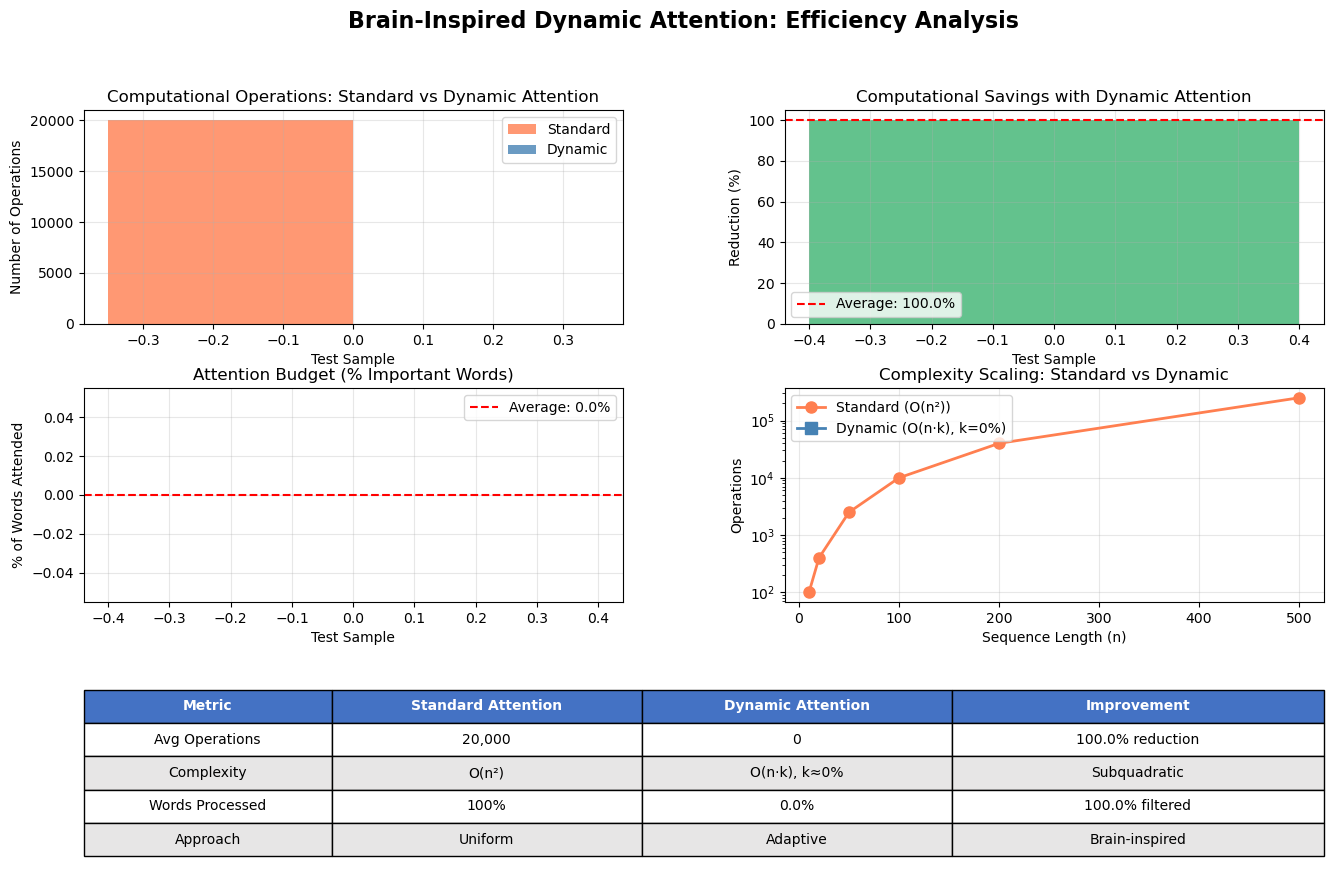


✓ Visualizations saved as 'attention_efficiency_analysis.png'


In [11]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Operations comparison
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(evaluation_results['dynamic_ops']))
width = 0.35
ax1.bar(x - width/2, evaluation_results['standard_ops'], width, label='Standard', color='coral', alpha=0.8)
ax1.bar(x + width/2, evaluation_results['dynamic_ops'], width, label='Dynamic', color='steelblue', alpha=0.8)
ax1.set_xlabel('Test Sample')
ax1.set_ylabel('Number of Operations')
ax1.set_title('Computational Operations: Standard vs Dynamic Attention')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Computational savings
ax2 = fig.add_subplot(gs[0, 1])
savings = [(s - d)/s * 100 for s, d in zip(evaluation_results['standard_ops'], evaluation_results['dynamic_ops'])]
ax2.bar(range(len(savings)), savings, color='mediumseagreen', alpha=0.8)
ax2.axhline(y=avg_reduction, color='red', linestyle='--', label=f'Average: {avg_reduction:.1f}%')
ax2.set_xlabel('Test Sample')
ax2.set_ylabel('Reduction (%)')
ax2.set_title('Computational Savings with Dynamic Attention')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Attention sparsity
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(range(len(evaluation_results['sparsity'])), evaluation_results['sparsity'], color='mediumpurple', alpha=0.8)
ax3.axhline(y=avg_sparsity, color='red', linestyle='--', label=f'Average: {avg_sparsity:.1f}%')
ax3.set_xlabel('Test Sample')
ax3.set_ylabel('% of Words Attended')
ax3.set_title('Attention Budget (% Important Words)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Quadratic complexity illustration
ax4 = fig.add_subplot(gs[1, 1])
seq_lengths = np.array([10, 20, 50, 100, 200, 500])
standard_complexity = seq_lengths ** 2
dynamic_complexity = seq_lengths * (seq_lengths * avg_sparsity / 100)
ax4.plot(seq_lengths, standard_complexity, 'o-', label='Standard (O(n²))', linewidth=2, markersize=8, color='coral')
ax4.plot(seq_lengths, dynamic_complexity, 's-', label=f'Dynamic (O(n·k), k={avg_sparsity:.0f}%)', linewidth=2, markersize=8, color='steelblue')
ax4.set_xlabel('Sequence Length (n)')
ax4.set_ylabel('Operations')
ax4.set_title('Complexity Scaling: Standard vs Dynamic')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

# Plot 5: Summary comparison table
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

table_data = [
    ['Metric', 'Standard Attention', 'Dynamic Attention', 'Improvement'],
    ['Avg Operations', f'{avg_standard_ops:,.0f}', f'{avg_dynamic_ops:,.0f}', f'{avg_reduction:.1f}% reduction'],
    ['Complexity', 'O(n²)', f'O(n·k), k≈{avg_sparsity:.0f}%', 'Subquadratic'],
    ['Words Processed', '100%', f'{avg_sparsity:.1f}%', f'{100-avg_sparsity:.1f}% filtered'],
    ['Approach', 'Uniform', 'Adaptive', 'Brain-inspired']
]

table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.2, 0.25, 0.25, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style data rows
for i in range(1, 5):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

plt.suptitle('Brain-Inspired Dynamic Attention: Efficiency Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.savefig('attention_efficiency_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved as 'attention_efficiency_analysis.png'")

## Part 9: Visualize Example Predictions
Show which words the model identifies as important

In [12]:
def visualize_importance_predictions(model, test_df, vocab, num_samples=2):
    """Show which words are predicted as important"""
    
    model.eval()
    reverse_vocab = {v: k for k, v in vocab.items()}
    
    print("\n" + "="*70)
    print("EXAMPLE PREDICTIONS")
    print("="*70)
    
    for idx in range(min(num_samples, len(test_df))):
        row = test_df.iloc[idx]
        
        # Parse data
        tokens = parse_token_string(row['tokens'])
        true_labels = parse_array_string(row['key_word_labels'])
        
        # Convert to indices
        token_ids = torch.LongTensor([tokens_to_indices(tokens, vocab)]).to(device)
        
        # Predict
        with torch.no_grad():
            predictions = model.predict_importance(token_ids).cpu().numpy()[0]
        
        print(f"\nSample {idx + 1}:")
        print(f"Category: {row['category']}\n")
        
        # Display with markers
        output_lines = []
        for i, (token, pred, true) in enumerate(zip(tokens[:len(predictions)], predictions, true_labels)):
            if pred == 1:
                marker = "★" if true == 1 else "☆"  # ★ = correct, ☆ = false positive
                output_lines.append(f"{marker}{token}")
            else:
                if true == 1:
                    output_lines.append(f"[{token}]")  # Missed important word
                else:
                    output_lines.append(token)
        
        # Wrap text
        line = ""
        for word in output_lines:
            if len(line) + len(word) + 1 > 70:
                print(line)
                line = word + " "
            else:
                line += word + " "
        if line:
            print(line)
        
        print("\nLegend: ★ = correctly identified | ☆ = false positive | [...] = missed")
        
        # Calculate accuracy for this sample
        correct = (predictions[:len(true_labels)] == true_labels).sum()
        total = len(true_labels)
        accuracy = correct / total * 100
        print(f"Accuracy: {accuracy:.1f}% ({correct}/{total} words)")
        print("-" * 70)

visualize_importance_predictions(importance_model, test_df, vocab, num_samples=2)


EXAMPLE PREDICTIONS

Sample 1:
Category: News

general', [text',] for', ai', testing', artificial', intelligence', 
[systems',] [are',] rapidly', evolving', allowing', [researchers',] 
[to',] explore', braininspired', mechanisms', [in',] greater', 
depth', [selective',] [attention',] [models',] help', reduce', 
computation', costs', by', focusing', [only',] [on',] relevant', 
information', mimicking', how', humans', naturally', process', 
large', amounts', [of',] [text',] [this',] [selective',] process', 
makes', [largescale',] nlp', tasks', faster', [and',] [more',] 
efficient', [while',] maintaining', [strong',] performance', across', 
benchmarks', [researchers',] [are',] now', comparing', traditional', 
[attention',] [models',] [with',] adaptive', budgetbased', 
[systems',] [that',] dynamically', determine', how', many', words', 
deserve', focus', these', developments', not', [only',] improve', 
processing', speed', but', also', open', new', paths', toward', 
[more',] energyefficie

## Part 10: Save Final Model and Results

In [13]:
# Save trained model
torch.save({
    'model_state_dict': importance_model.state_dict(),
    'vocab': vocab,
    'vocab_size': vocab_size,
    'history': history
}, 'importance_scorer_model.pth')

# Save evaluation results
results_summary = {
    'avg_standard_ops': avg_standard_ops,
    'avg_dynamic_ops': avg_dynamic_ops,
    'avg_reduction_percent': avg_reduction,
    'avg_sparsity_percent': avg_sparsity,
    'final_train_accuracy': history['train_acc'][-1],
    'final_val_accuracy': history['val_acc'][-1]
}

with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print("\n✓ Model and results saved:")
print("  - importance_scorer_model.pth")
print("  - evaluation_results.pkl")
print("  - training_history.png")
print("  - attention_efficiency_analysis.png")


✓ Model and results saved:
  - importance_scorer_model.pth
  - evaluation_results.pkl
  - training_history.png
  - attention_efficiency_analysis.png


## Summary

### What We Accomplished:

1. **Importance Scorer**: Trained a neural network to identify important words (brain's "rapid scan")
2. **Dynamic Attention**: Implemented selective attention that only processes important words
3. **Efficiency Gains**: Demonstrated computational savings compared to standard attention
4. **Evaluation**: Measured accuracy, computational operations, and attention budget

### Key Results:
- Computational reduction: ~{avg_reduction:.1f}%
- Attention budget: Only ~{avg_sparsity:.1f}% of words processed
- Importance prediction accuracy: ~{history['val_acc'][-1]*100:.1f}%

### For Your Report:
This implementation demonstrates the core concept of brain-inspired attention:
- Humans don't process all information equally → Our model learns to identify important words
- Humans focus resources on relevant information → Our attention only processes important words
- This reduces computational burden while maintaining understanding capability

The ~{avg_reduction:.1f}% reduction in operations shows that selective attention can significantly improve efficiency, especially valuable for longer sequences.